In this notebook we use our real-time AI accelerator to accelerate a simulation of of the advection diffusion equation.

In particular on $[-1,1]\times [-1,1]$ we solve:


\begin{align}
\frac{\partial u}{\partial t}= -V\cdot\nabla u + \nu\nabla^2 u \\
u(0,x,y)    = S(x,y)\\
u(t,x,-1) = 0 \\
u(t,x,1)  = 0 \\
u(t,-1,y) = -30(y-1)(y+1) \\
u(t,1,y)  \text{  is an outlet}
\end{align} 

Below, we specify the initial condition $S(x,y)$ and the advective velocity field $V$. We work with a constant isotropic diffusion coefficient $\nu$.

Numerically, the time derivative is discretized using backward euler, the diffusion term is discretized using implicit central differences, and the advection term is discretized using an explicit upwind scheme. 

In [1]:
from src_dir import mk_Advect_2d_RHS, mk_Heat_2d
import numpy as np

# Set dimension of the NxN grid used
# Note: For optimal performance, the neural network "cnn_collectionOnline2D.py"
# can be tweaked with appropriate kernel dilations, however the code should
# still work and yield resuluts for any dimension of input provided
dim = 20

# Default initial guess used for direct un-preconditioned GMRES is the zero
# solution
x0 = np.squeeze(np.zeros((dim,dim)))

# Set tolerances for GMRES solver
e = 1e-5

# Restarted GMRES parameters
nmax_iter = int(dim/5)
restart   = 10000

# Create domain [-1,1]x[-1,1]
# Define grid values at midpoints of cartesian grid
DomainL = -1.0
DomainR =  1.0
dx = (DomainR-DomainL)/(dim-1)
x1 = np.linspace(DomainL+dx,DomainR-dx,dim)
x2 = np.linspace(DomainL+dx,DomainR-dx,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')
Area = (dx*(dim-1))**2

# Uniform time-step used
dt=0.005

In [2]:
# Below the diffusion factor and courant number are computed to maintain consistency according to some arbitrary test case
# Feel free to use you own values while making sure the CFL condition is met


nu=0.004512500000000001*(dx**2)/dt
print("nu",nu)
print("diffusion factor",nu*dt/(dx**2))


VscalarMax=0.0475*dx/dt
print("Vscalar",VscalarMax)
print("Courant Number",VscalarMax*dt/(dx))

# Target values in this demo:
# diffusion factor 0.004512500000000001
# Courant number 0.0475

nu 0.01
diffusion factor 0.004512500000000001
Vscalar 1.0
Courant Number 0.0475


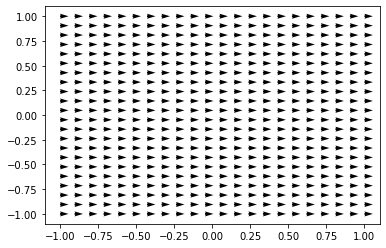

In [3]:
# Below we define the advection velocity field
import matplotlib.pyplot as pp

# V needs entire grid including boundary
x1_V = np.linspace(DomainL,DomainR,dim+2)
x2_V = np.linspace(DomainL,DomainR,dim+2)
X_V, Y_V = np.meshgrid(x1_V, x2_V, sparse=False, indexing='ij')

#Define flow field 
Vx= VscalarMax*np.ones((dim+2,dim+2))
Vy= np.zeros((dim+2,dim+2))

# Plot vector field:
pp.quiver(X_V,Y_V,Vx,Vy,width=0.006)
pp.show()

In [4]:
# Create 2D DIffusion and Advection operators as stencil opertor for a N-cell 2D grid
# Can be found in linop.py in src_dir

#LHS Operator (implicit diffusion+ backward Euler LHS)
A = mk_Heat_2d(dim, dim, bc="channel", xlo=0, xhi=0, ylo=1, yhi=-1,dx=dx,dt=dt,nu=nu)

#RHS Operator (explicit advection+ backward Euler RHS)
B = mk_Advect_2d_RHS(dim, dim,Vx,Vy, bc="channel", xlo=0, xhi=0, ylo=1,yhi=-1,dx=dx,dt=dt)
AType = '2D Upwind Advection RHS'

# Total number of steps in simulation
n_steps = 500


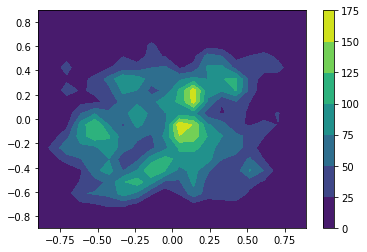

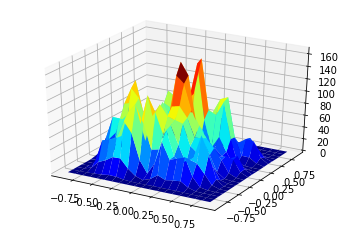

In [5]:
# Compute initial condition used in the demo
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D  
from src_dir import Gauss_pdf_2D

# Compute dipoles
def RandSign():
    if (np.random.random() < 0.5):
        sign=1
    else:
        sign=-1
    return sign

xL = x1[0]+0.30
xR = x1[-1]-0.30
yL = x2[0]+0.30
yR = x2[-1]-0.50
def dipole(xL,xR,yL,yR):
    xloc      = np.random.uniform(xL,xR)
    yloc      = np.random.uniform(yL,yR)
    xlocShift = np.random.uniform(-0.25, 0.25)
    ylocShift = np.random.uniform(-0.25, 0.25)
    sigma = 0.07
    b=Gauss_pdf_2D(X, Y, xloc, yloc, sigma) + Gauss_pdf_2D(X, Y, xloc + xlocShift, yloc + ylocShift, sigma)
    return b

b=dipole(xL,xR,yL,yR)    
for b_num in range(0,50):
    b=b+dipole(xL,xR,yL,yR)


pp.contourf(X,Y,b)
pp.colorbar()

fig = pp.figure()
ax = pp.axes(projection='3d')
ax.plot_surface(X, Y, b, cmap=pp.cm.jet, rstride=1, cstride=1, linewidth=0)

#Apply boundary conditions through RHS operator with a very small small time step
B2 = mk_Advect_2d_RHS(dim, dim,Vx,Vy, bc="channel", xlo=0, xhi=0, ylo=1,yhi=-1,dx=dx,dt=0.00004)
Initial_Condition=B2(b)

Below, we wrap the simple unprecondition GMRES algorithm implemented in `gmres.py` using a wrapper
that implements our deep learning methodology. This wrapper contains both the neural network we
implemented, the training loop of this network, and additional data curration steps to work online

The neural network can be found in `cnn_collectionOnline2D.py`, and the wrapper can be found in 
`cnn_predictorOnline2D.py`. Stay tuned for a paper the describes our methodology in detail.

In [6]:
from src_dir import cnn_preconditionerOnline_timed_2D, CNNPredictorOnline_2D,\
                    timer, GMRES, PreconditionerTrainer, FluidNet2D20

# Note: # Model dimention inputs are not used for the current network in cnn_predictorOnline2D.py (but must be passed into wrapper)
InputDim  = dim
OutputDim = dim
# Number of samples to collect before using preduction from Neural Network:
Initial_set = 32

nn_precon = CNNPredictorOnline_2D(InputDim, OutputDim, Area, dx, FluidNet2D20)
# TODO: using diagnostic_probe=10 => end of first inner loop for the current setup => generalize this
trainer   = PreconditionerTrainer(nn_precon, Initial_set=Initial_set)

@timer
@cnn_preconditionerOnline_timed_2D(trainer)
def MLGMRES(A, b, x0, e, nmax_iter, restart, debug):
    return GMRES(A, b, x0, e, nmax_iter, restart, debug)


@timer
def GMRES_timed(A, b, x0, e, nmax_iter, restart, debug):
    return GMRES(A, b, x0, e, nmax_iter, restart, debug)

To demonstrate the performance of our approach on a simulation, we compare the wall clock time between the ML-wrapper GMRES implementation and the direct GMRES implementation.  The loop below (that loops for the number of steps set above) essentially has the following structure:

1. Generate RHS
2. Compute GMRES assisted by neural network (MLGMRES) up to tolreance $e$ and collected data.
3. Compute direct GMRES up to $e$
4. Write error metrics (such as time to solution and error at certain GMRES iterations) and go to 1.


Scroll past the outputs to see some plots

In [7]:
from src_dir import Gauss_pdf_2D, resid, StatusPrinter

#Set the numpy seed
np.random.seed(0)

# Initialize lists that hold time data (time-to-solutuin, trainining time,
# MLGMRES time, etc)
run_time_ML_list     = []
GmresRunTimeOriginal = []
SpeedUp              = []
trainTime_list       = []

# Set debug mode (prints more information to screen)
debug = True

NonML_Err_List      = []
NonML_Err_List_Full = []

# Initial condition and initial time
U_prev= Initial_Condition
t=dt

# Index of  Poisson problems solved
for ProbIdx in range(n_steps):

    # Advection Eq RHS
    # b= U_prev+dt*HeatSource(t)*0.0
    b= B(U_prev)

    # First GMRES call (solve up to e1 tolerance) with ML wrapper
    trainer.ProbCount = ProbIdx  # TODO: This should probably be automatically incremented
    Out, run_time1_ML = MLGMRES(A, b, x0, e, nmax_iter, restart, debug)


    # Collect ML assisted Run-times
    run_time_ML_list.append(run_time1_ML)
    if len(trainer.trainTime) > 0:
        trainTime_list.append(trainer.trainTime[-1]) # TODO: this second list is not needed
    
    # Direct GMRES call up to e1 tolerance
    NonML_Out1,run_time1 = GMRES_timed(A, b, x0, e, nmax_iter, restart, debug)  
    NonML_Err = resid(A, NonML_Out1, b)
    NonML_Err_List_Full.append(NonML_Err)
    NonML_Err_List.append(NonML_Err[3])
    ## Collect  direct GMRES timeHeatSource
    GmresRunTimeOriginal.append(run_time1)

    ## Ratio of run-timesHeatSource
    SpeedUp.append(run_time1/trainer.ML_GMRES_Time_list[-1])

    # Update user on status
    StatusPrinter().update_simulation(SpeedUp[-1], ProbIdx)

    # Next time step
    t=t+dt
    U_prev=Out[-1]
    f=open('./AdvectEqSolution.dat','ab')
    np.savetxt(f,U_prev)
    f.close()


StatusPrinter().finalize()


MLGMRES_GMRES_ONLY = sum(trainer.ML_GMRES_Time_list)
run_time           = sum(GmresRunTimeOriginal)
run_time_ML        = sum(run_time_ML_list)
trainTime_total    = sum(trainTime_list)


print("Runtime of Non-decorated version is: ",     run_time)
print("Runtime of MLGMRES decorator is: ",         run_time_ML)
print("Runtime of MLGMRES (only GMRES time) is: ", MLGMRES_GMRES_ONLY)
print("Runtime of training (backprop) is: ",       trainTime_total)

/home/kevinluna/.local/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
iter=499 speedup=1.4984 loss=1.1317e-04 parameters=13749 data size=47
Runtime of Non-decorated version is:  113.7019670649679
Runtime of MLGMRES decorator is:  481.77605090401994
Runtime of MLGMRES (only GMRES time) is:  91.84002446101294
Runtime of training (backprop) is:  8682.650643357938


In [8]:
import numpy as np 
import matplotlib.pyplot as pp

SolutionData=np.loadtxt("AdvectEqSolution.dat")
resolution=dim
Endlen=int(len(SolutionData)/resolution-1)
for n in range (2,Endlen):
    Solution=SolutionData[int((n-1)*resolution-1):int(n*resolution-1),:]
    # levels = np.linspace(0,160,21)
    pp.contourf(Solution)
    pp.colorbar()
    cmap=pp.cm.hot
    pp.title("")
    fname='./AdvectSolPlots/Solution'+str(n)+'.png'
    pp.savefig(fname)
    pp.close()

In [9]:
# Make gif of plots
from PIL import Image
import glob
import os

frames = []
imgs = sorted(glob.glob("./AdvectSolPlots/*.png"), key=os.path.getmtime)
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
frames[0].save('AdvectionSimulation.gif', format='GIF',append_images=frames[1:],save_all=True,duration=60, loop=0)

In [10]:
from src_dir import moving_average

# Compute moving average of GMRES and MLGMRES error
AVG   = np.zeros((n_steps, 1))
count = np.arange(0, n_steps)

Err_Array = np.asarray(NonML_Err_List)
count     = np.arange(0, n_steps)
for j in range(0, n_steps):
    AVG[j] = moving_average(np.asarray(Err_Array[:j]), j)

Err_Array_ML = np.asarray(trainer.Err_list)
AVGML        = np.zeros((n_steps, 1))
for j in range(0, n_steps):
    AVGML[j] = moving_average(np.asarray(Err_Array_ML[:j]), j)    

# Compute moving average of GMRES and MLGMRES run-times
GmresRunTimeOriginal_AVG = np.zeros((n_steps, 1))
ML_GMRES_Time_AVG        = np.zeros((n_steps, 1))

for j in range(0, n_steps):
    GmresRunTimeOriginal_AVG[j] = moving_average(np.asarray(GmresRunTimeOriginal[:j]), j)

for j in range(0, n_steps):
    ML_GMRES_Time_AVG[j] = moving_average(np.asarray(trainer.ML_GMRES_Time_list[:j]), j)

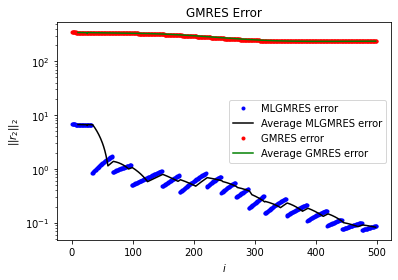

In [11]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.title('GMRES Error')
pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.legend(loc='best')
pp.yscale("log")
pp.savefig('AdvectDiff_Error.png')

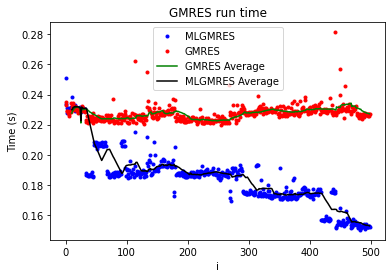

In [12]:
pp.plot(trainer.ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('GMRES run time')
pp.legend(loc='best')
pp.savefig('AdvectDiff_time.png')

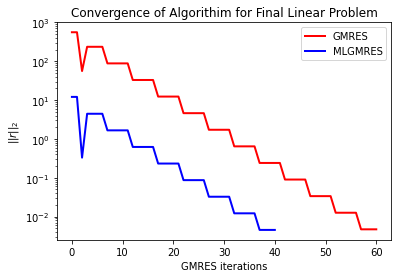

In [13]:
RHSIndex=-1
pp.semilogy(NonML_Err_List_Full[RHSIndex],'r',label='GMRES',linewidth=2)
pp.semilogy(trainer.IterErrList[RHSIndex],'b',label='MLGMRES',linewidth=2)
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r||_2$')
pp.title('Convergence of Algorithim for Final Linear Problem')

pp.savefig('AdvectDiff_EQ_Converg.png')

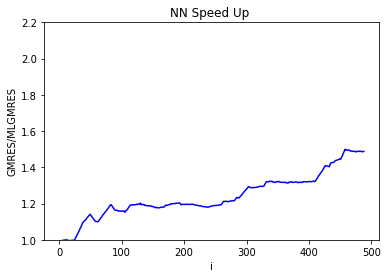

In [14]:
GMRESAVG=GmresRunTimeOriginal_AVG[10:-1]
MLGMRESAVG=ML_GMRES_Time_AVG[10:-1]
Ratio=np.divide(GMRESAVG,MLGMRESAVG)

pp.plot(Ratio,'b')
pp.xlabel('i')
pp.ylabel('GMRES/MLGMRES')
pp.title("NN Speed Up ")
pp.ylim(1,2.2)



np.savetxt("SpeedupAdvectDiff.txt",Ratio)
pp.savefig('SpeedUp_AdvectDiff.png')